Der Code erzeugt eine CSV-Datei, welche man nur noch minimal von Hand nachbearbeiten muss (annotations hinzufügen und fieldnames editieren)

Diese Datei kann man dann über das UI von influx OSS (v2.x) importieren und bekommt folgende Struktur:

| Measurement: | elektrischearbeit |
| :- | :- |
| Field Keys:  | erzeugt |
| Tag Keys:    | ort,gebaeude,anlage,messgeraet |

Simuliert wird der Verlauf des Ertrags (Elektrische Arbeit in Wh) einer Solaranlage, die pro Tag 3000 Wh liefert.


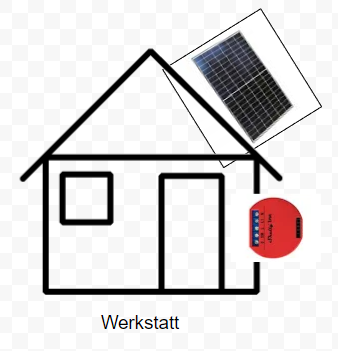

In [1]:
import numpy as np
import math
import pandas as pd
import datetime
import csv


# liefert den Verlauf des Solarertrags einer Solaranlage, die pro Tag 3kWh Energie erzeugt
# zu jeder übergebenen Minute wird der Zählerstand des Energiezählers zurückgegeben
def solarertrag( minute):
  return 1500*(np.tanh(0.01*minute-7)+1)


#das CSV wird aus einem Array aus Dicts generiert
energy_array = []
#aktuelles Datetime holen
now = datetime.datetime.now()
#simuliert werden soll für die vergangenen 24h + 1h Puffer
start = now - datetime.timedelta(hours=25)

#die namen der Spalten im CSV
field_names = ['none', 'result', 'table', '_time', '_value', '_field', '_measurement', 'ort', 'gebaeude', 'anlage', 'messgeraet']

#24h sind 1440 Minuten, für jede Minute soll ein Messwert für die Solaranlage generiert werden
for minute in range(1440):
  timestamp = start + datetime.timedelta(minutes=minute)
  #Dict bauen
  SolarRowdict = dict(none = "", result = "", table = 0, _time = timestamp.isoformat(timespec='seconds')+"Z", _value = solarertrag(minute), _field = "erzeugt", _measurement = "elektrischearbeit", ort="Rohnstedt", gebaeude="Werkstatt", anlage="Solaranlage", messgeraet="shelly1pm")
  PumpeRowdict = dict(none = "", result = "", table = 1, _time = timestamp.isoformat(timespec='seconds')+"Z", _value = (200/60)*minute, _field = "bezogen", _measurement = "elektrischearbeit", ort="Rohnstedt", gebaeude="Poolhaus", anlage="Pumpe", messgeraet="shelly1pm")
  #Dict in das Array legen
  energy_array.append(SolarRowdict)
  energy_array.append(PumpeRowdict)

#aus dem array aus dicts ein CSV bauen
with open('solarertrag.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()
    writer.writerows(energy_array)


Das Annotated CSV-Format für influx2 muss so aussehen. Die Annotations muss man von Hand mit einem Editor hinzufügen und das none in den field_names muss entfernt werden.

```
#group,false,false,false,false,true,true,true,true,true,true
#datatype,string,long,dateTime:RFC3339,double,string,string,string,string,string,string
#default,_result,,,,,,,,,
none,result,table,_time,_value,_field,_measurement,ort,gebaeude,anlage,messgeraet
,,0,2024-02-03T13:27:19Z,0.0024945840829682098,erzeugt,elektrischearbeit,Rohnstedt,Werkstatt,Solaranlage,shelly1pm
,,1,2024-02-03T13:27:19Z,0.0,bezogen,elektrischearbeit,Rohnstedt,Poolhaus,Pumpe,shelly1pm



```



Importiert man das dann in ein bucket, sieht der Verlauf so aus (tanh() ist gut erkennbar)



```
from(bucket: "Sensorik")
  |> range(start: -24h)
  |> filter(fn: (r) => r["_measurement"] == "elektrischearbeit")
  |> filter(fn: (r) => r["_field"] == "erzeugt")
  |> filter(fn: (r) => r["anlage"] == "solaranlage")
  |> filter(fn: (r) => r["gebaeude"] == "Werstatt")
  |> filter(fn: (r) => r["messgeraet"] == "shelly1pm")
  |> filter(fn: (r) => r["ort"] == "Rohnstedt")
  |> aggregateWindow(every: 1m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
```



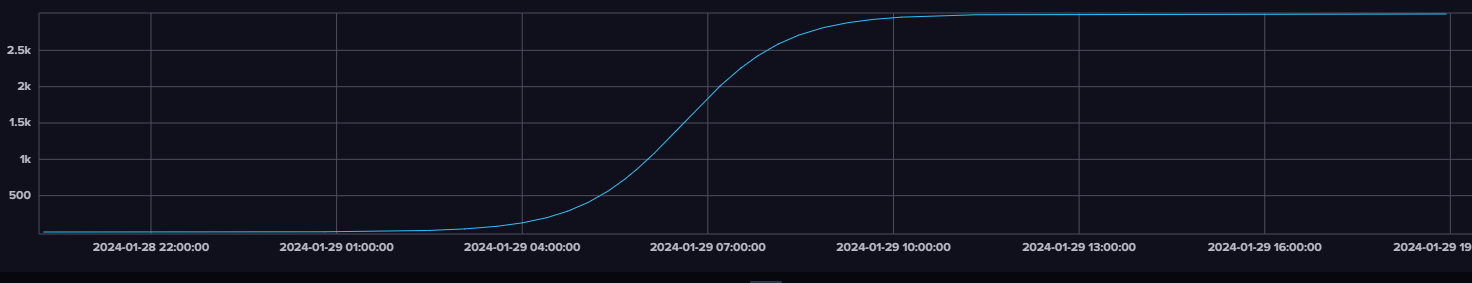


Wenn man aus dem Verlauf der Arbeit den Verlauf der Leistung haben will, macht man das

(Achtung, wenn etwas anderes als 5-Minuten Zeitfenster genommen werden, musss auch die Berechnung der Leistung auf die Fensterbreite angepasst werden.)
```
from(bucket: "Sensorik")
  |> range(start: -24h)
  |> filter(fn: (r) => r["_measurement"] == "elektrischearbeit")
  |> filter(fn: (r) => r["_field"] == "erzeugt")
  |> filter(fn: (r) => r["anlage"] == "solaranlage")
  |> filter(fn: (r) => r["gebaeude"] == "Werstatt")
  |> filter(fn: (r) => r["messgeraet"] == "shelly1pm")
  |> filter(fn: (r) => r["ort"] == "Rohnstedt")
  |> aggregateWindow(every: 5m, fn: last, createEmpty: false)
  |> difference()
  |> map(fn: (r) => ({ r with _value: r._value * 60.0 / 5.0 }))
  |> yield(name: "mean")
```

Das sieht dann so aus:



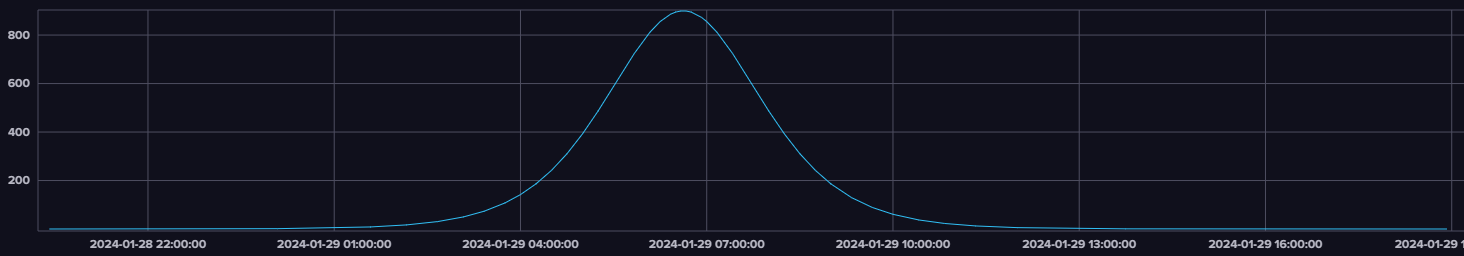

Wenn man mit werten aus 2 tabellen rechnen will, muss man erst ein pivot machen und kann dann rechnen:


```
from(bucket: "Sensorik")
  |> range(start: -24h)
  //|> filter(fn: (r) => r["_measurement"] == "elektrischearbeit")
  |> filter(fn: (r) => r["_field"] == "bezogen" or r["_field"] == "erzeugt")
  |> drop(columns: ["_measurement", "anlage", "gebaeude", "messgeraet", "ort"])
  |> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> map(fn: (r) => ({ r with _value: r.bezogen - r.erzeugt }))
  
  |> aggregateWindow(every: 5m, fn: last, createEmpty: false)
  |> difference()
  |> map(fn: (r) => ({ r with _value: r._value * 60.0 / 5.0 }))

  |> yield(name: "mean")
```

